In [1]:

import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd

import torch.nn as nn

In [2]:
image_dir = "cavallo"

images = []
for filename in os.listdir(image_dir):
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)

    if image is not None:
        image = cv2.resize(image, (128, 128))
        images.append(image)

print("Number of images read:", len(images))

Number of images read: 2623


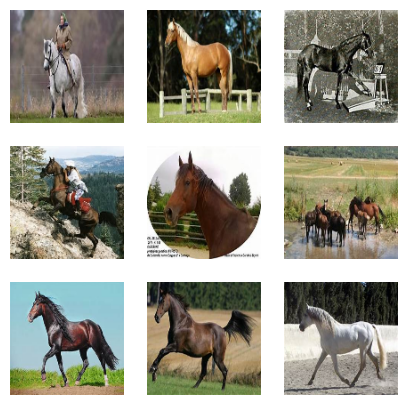

In [3]:
# example of dataset
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.axis('off')

plt.show()

In [4]:
def divide_image(image):
    parts = []
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3
    
    for i in range(3):
        for j in range(3):
            part = image[i*part_height:(i+1)*part_height, j*part_width:(j+1)*part_width]
            parts.append(part)
    
    return parts

In [5]:
def generate_combinations(parts, num_combinations):
    combinations = []
    original_positions = []
    indices = list(range(len(parts)))
    
    for _ in range(num_combinations):
        random.shuffle(indices)
        combination = [parts[i] for i in indices]
        combinations.append(combination)
        original_positions.append(indices.copy())
    
    return combinations, original_positions

In [6]:
def stitch_shuffled_image(parts):
    num_parts = len(parts)
    part_size = parts[0].shape[0]  # Assuming all parts are square
    
    stitched_image_size = int(np.sqrt(num_parts) * part_size)
    stitched_image = np.zeros((stitched_image_size, stitched_image_size, parts[0].shape[2]), dtype=np.uint8)
    
    for i in range(stitched_image.shape[0] // part_size):
        for j in range(stitched_image.shape[1] // part_size):
            part_index = i * int(stitched_image.shape[0] / part_size) + j
            stitched_image[i*part_size:(i+1)*part_size, j*part_size:(j+1)*part_size] = parts[part_index]
    
    return stitched_image

In [7]:
input_data = []
target_data = []
non_converted_target_data = []

for image in images:
    parts = divide_image(image)
    combinations, original_positions = generate_combinations(parts, 10)
    
    for idx, combination in enumerate(combinations):

        # shape of combination is (9, 40, 40, 3)
        combination = np.array(combination).transpose(0, 3, 1, 2)
        combination = np.concatenate(combination, axis=0).transpose(1, 2, 0)
        input_data.append(combination)

        dummy_target = np.zeros((9, 9), dtype=np.uint8)
        for i in range(9):
            dummy_target[i, original_positions[idx][i]] = 1

        target_data.append(dummy_target.flatten())
        non_converted_target_data.append(original_positions[idx])

In [8]:
input_data = np.array(input_data)
target_data = np.array(target_data)

print("Input data shape:", input_data.shape)
print("Target data shape:", target_data.shape)

Input data shape: (26230, 42, 42, 27)
Target data shape: (26230, 81)


In [9]:
# select random image
idx = random.randint(0, len(input_data))
print("target", target_data[idx].reshape(9, 9), sep="\n")
print("non_converted_target", non_converted_target_data[idx])

target
[[0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0]]
non_converted_target [8, 5, 4, 7, 6, 3, 0, 1, 2]


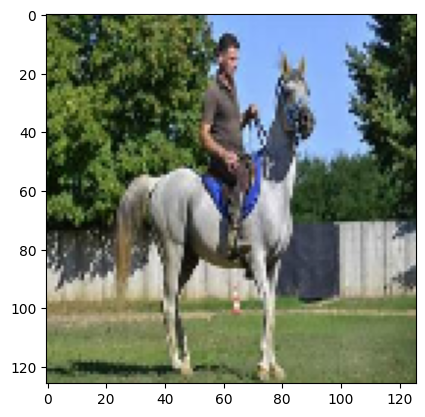

In [10]:
# checking if the target sequence is correct
# checking if the target sequence is correct
def reconstructed_image(img, non_converted_target_data, test=False):
    
    sequenced = [0] * 9
    for i in range(0,27,3):

        # stack the 3 channels to get the original image
        blue_channel = img[:,:,i]
        green_channel = img[:,:,i+1]
        red_channel = img[:,:,i+2]

        # stack the 3 channels to get the original image
        tile = np.stack((blue_channel, green_channel, red_channel), axis=2)

        if test:
            sequenced[i // 3] = tile
        else:
            sequenced[non_converted_target_data[i // 3]] = tile

    stiched_img = stitch_shuffled_image(sequenced)
    return stiched_img


reconstructed_img = reconstructed_image(input_data[idx], non_converted_target_data[idx])
plt.imshow(cv2.cvtColor(reconstructed_img, cv2.COLOR_BGR2RGB))

In [11]:
import torch.optim as optim



In [12]:
class JigsawDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        self.transform = transform
        
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        image = self.input_data[idx]
        target = self.target_data[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(planes, planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU(inplace=True)

        self.avgpool = nn.AvgPool2d(stride) if stride > 1 else nn.Identity()

        self.conv3 = nn.Conv2d(planes, planes * self.expansion, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu3 = nn.ReLU(inplace=True)

        self.downsample = None
        self.stride = stride

        if stride > 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(OrderedDict([
                ("-1", nn.AvgPool2d(stride)),
                ("0", nn.Conv2d(inplanes, planes * self.expansion, 1, stride=1, bias=False)),
                ("1", nn.BatchNorm2d(planes * self.expansion))
            ]))

    def forward(self, x):
        identity = x

        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.relu2(self.bn2(self.conv2(out)))
        out = self.avgpool(out)
        out = self.bn3(self.conv3(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu3(out)
        return out
    

    
class AttentionPool2d(nn.Module):
    def __init__(self, spacial_dim, embed_dim, num_heads, output_dim=None):
        super(AttentionPool2d, self).__init__()
        self.positional_embedding = nn.Parameter(torch.randn(spacial_dim ** 2 + 1, embed_dim) / embed_dim ** 0.5)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.c_proj = nn.Linear(embed_dim, output_dim or embed_dim)
        self.num_heads = num_heads

    def forward(self, x):
        x = x.flatten(start_dim=2).permute(2, 0, 1)  # NCHW -> (HW)NC
        x = torch.cat([x.mean(dim=0, keepdim=True), x], dim=0)  # (HW+1)NC
        x = x + self.positional_embedding[:, None, :].to(x.dtype)  # Add positional embedding

        x, _ = F.multi_head_attention_forward(
            query=x[:1], key=x, value=x,
            embed_dim_to_check=x.shape[-1],
            num_heads=self.num_heads,
            q_proj_weight=self.q_proj.weight,
            k_proj_weight=self.k_proj.weight,
            v_proj_weight=self.v_proj.weight,
            in_proj_weight=None,  # Use separate projection weights, provided next
            in_proj_bias=torch.cat([self.q_proj.bias, self.k_proj.bias, self.v_proj.bias]),
            bias_k=None,
            bias_v=None,
            add_zero_attn=False,
            dropout_p=0,
            out_proj_weight=self.c_proj.weight,
            out_proj_bias=self.c_proj.bias,
            training=self.training,
            need_weights=False,
            use_separate_proj_weight=True,
            key_padding_mask=None,
            attn_mask=None,
        )

        return x.squeeze(0).view(x.size(1), -1, 1, 1)  # Reshape output to (N, C, 1, 1)

    

class ModifiedResNet(nn.Module):
    def __init__(self, layers, output_dim, heads, input_resolution=128, width=64):
        super(ModifiedResNet, self).__init__()
        self.output_dim = output_dim
        self.input_resolution = input_resolution

        self.conv1 = nn.Conv2d(27, width // 2, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(width // 2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(width // 2, width // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(width // 2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.Conv2d(width // 2, width, kernel_size=3, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(width)
        self.relu3 = nn.ReLU(inplace=True)
        self.avgpool = nn.AvgPool2d(2)

        self._inplanes = width
        self.layer1 = self._make_layer(width, layers[0])
        self.layer2 = self._make_layer(width * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(width * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(width * 8, layers[3], stride=2)

        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, 512) 
        self.fc3 = nn.Linear(512, 81)

        self.embed_dim = width * 32

        self.attnpool = AttentionPool2d(3, self.embed_dim, heads, output_dim)

    def _make_layer(self, planes, blocks, stride=1):
        layers = [Bottleneck(self._inplanes, planes, stride)]
        self._inplanes = planes * Bottleneck.expansion
        for _ in range(1, blocks):
            layers.append(Bottleneck(self._inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x,list1):
        feature_list = []
        x = x.type(self.conv1.weight.dtype)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.avgpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        list1.append(x)
        x = self.layer3(x)
        x = self.layer4(x)
        list1.append(x)
        print(x.shape)
        x = self.attnpool(x)
        x = x.view(64,64 * 32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # print("hia",self.embed_dim,x)
        # x = self.attnpool(x)
        return x,list1
 

In [18]:
model = ModifiedResNet(layers=[3, 4, 6, 3], output_dim=2048, heads=8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 64
num_epochs = 10

In [19]:
X_train, X_test, y_train, y_test = train_test_split(input_data, target_data, test_size=0.2, random_state=42)

train_dataset = JigsawDataset(X_train, y_train)
test_dataset = JigsawDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [20]:


model.train()  

feature_list = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # print(labels.shape)
        inputs = inputs.permute(0, 3, 1, 2).float()
        
        feature_list.append(inputs)
        

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs,features = model(inputs,feature_list)  # Adjust this if your model returns more than one output
        # print(outputs.shape)

        # Compute the loss
        loss = criterion(outputs, labels.float())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:  # Print every 100 mini-batches
            print(f'Epoch: {epoch + 1}, Batch: {i + 1}, Loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

torch.Size([64, 2048, 1, 1])


RuntimeError: The size of tensor a (2) must match the size of tensor b (10) at non-singleton dimension 0

In [ ]:
feature_list[0][0].shape

In [ ]:
labels.shape

In [ ]:
plt.imshow(feature_list[0][0][0].detach().numpy())

In [ ]:
plt.imshow(feature_list[1][0][0].detach().numpy())

In [ ]:
plt.imshow(feature_list[2][0][0].detach().numpy())

In [ ]:
mean_x = feature_list[0].mean(dim=1, keepdim=True)

mean_x

In [ ]:
plt.imshow(mean_x[0][0].detach().numpy())

In [ ]:
mean_x = feature_list[1].mean(dim=1, keepdim=True)

mean_x

In [ ]:
plt.imshow(mean_x[1][0].detach().numpy())

In [ ]:
mean_x = feature_list[2].mean(dim=1, keepdim=True)

mean_x

In [ ]:
plt.imshow(mean_x[1][0].detach().numpy())